In [101]:
#ライブラリ、モジュールのインポート
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.font_manager as fm
import geopandas as gpd
#import xml.etree.ElementTree as ET

In [102]:
#Excelデータのパスを指定
#公園種別、所在地、面積、設備
file_path_1 = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ).xlsx'
# #人口密度
file_path_2 = '/home/yasumasa-tezuka/intern_data/jinkotosetai_r5_10.xlsx'
# #行政区域の面積
file_path_3 = '/home/yasumasa-tezuka/intern_data/2-05.xlsx'
#フォントのパス
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc' 

In [103]:
# 公園データの読み込み
park_data = pd.read_excel(file_path_1)
#人口密度
population_density = pd.read_excel(file_path_2)
#行政区域面積
administrative_area = pd.read_excel(file_path_3)

In [104]:
print(park_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8031 entries, 0 to 8030
Data columns (total 54 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   No.             8030 non-null   float64
 1   自治体名            8030 non-null   object 
 2   名称              8030 non-null   object 
 3   所在地             8029 non-null   object 
 4   提供開始年           8030 non-null   object 
 5   面積              8030 non-null   object 
 6   公園種別            8030 non-null   object 
 7   トイレ             8031 non-null   object 
 8   多目的トイレ          8030 non-null   object 
 9   水飲み・手洗い         8030 non-null   object 
 10  スプリング遊具・スイング遊具  8027 non-null   object 
 11  砂場              8027 non-null   object 
 12  複合遊具            8027 non-null   object 
 13  健康器具            8026 non-null   object 
 14  ブランコ            8027 non-null   object 
 15  すべり台            8027 non-null   object 
 16  ジャングルジム         8027 non-null   object 
 17  鉄棒              8027 non-null   o

In [105]:
# 面積列を数値型に変換し、NaNを削除（あるいは別の値で置き換え）
park_data['面積'] = pd.to_numeric(park_data['面積'], errors='coerce')
park_data.dropna(subset=['面積'], inplace=True)  # NaNを含む行を削除

# 公園のカテゴリを定義（例：小規模＜1000平方メートル、中規模＜10000平方メートル、大規模≥10000平方メートル）
def categorize_park(area):
    if area < 1000:
        return '小規模'
    elif area < 10000:
        return '中規模'
    else:
        return '大規模'
    
# 各公園にカテゴリを割り当てる
park_data['カテゴリ'] = park_data['面積'].apply(categorize_park)

# カテゴリ別に公園の数を集計
category_counts = park_data['カテゴリ'].value_counts()

# 結果を表示
print(category_counts)

カテゴリ
小規模    3855
中規模    3469
大規模     705
Name: count, dtype: int64


In [106]:
# データの読み込み
file_path_1 = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ).xlsx'
park_data = pd.read_excel(file_path_1)

# 数値に変換する列のリスト
numeric_columns = ['トイレ', '多目的トイレ', '水飲み・手洗い', 'スプリング遊具・スイング遊具', '砂場', '複合遊具', '健康器具', 'ブランコ', 'すべり台', 'ジャングルジム', '鉄棒', 'シーソー', 'ターザンロープ', 'ローラースライダー', 'ふわふわドーム', '芝生広場', '水遊び', 'ランニングコース', 'テニスコート', 'バスケットゴール', '野球場', 'フットサル場', 'サッカー場', 'スケートパーク', 'プール', '体育館', '陸上競技場', 'ウサギ・モルモット', 'ハムスター', 'ひよこ', '馬・ポニー', 'カフェ・飲食施設', '売店', '自動販売機', 'バーベキュー場', 'ドッグラン', '喫煙所', 'イベント広場', '避難場所', '無料駐車場', '有料駐車場', '駐輪場']

# 対象の列のみを数値に変換
for column in numeric_columns:
    park_data[column] = pd.to_numeric(park_data[column], errors='coerce')

# 合計の計算（NaN値は無視される）
sums = park_data[numeric_columns].sum()

# 結果の出力
print(sums)


トイレ               1191.0
多目的トイレ             674.0
水飲み・手洗い           5499.0
スプリング遊具・スイング遊具    1120.0
砂場                3362.0
複合遊具              1700.0
健康器具              1002.0
ブランコ              2655.0
すべり台              2768.0
ジャングルジム            395.0
鉄棒                2270.0
シーソー               280.0
ターザンロープ             82.0
ローラースライダー           31.0
ふわふわドーム              9.0
芝生広場               107.0
水遊び                 28.0
ランニングコース            21.0
テニスコート              72.0
バスケットゴール            42.0
野球場                 76.0
フットサル場               4.0
サッカー場               21.0
スケートパーク              6.0
プール                 53.0
体育館                 13.0
陸上競技場               12.0
ウサギ・モルモット            8.0
ハムスター                1.0
ひよこ                  1.0
馬・ポニー                6.0
カフェ・飲食施設            25.0
売店                  32.0
自動販売機              161.0
バーベキュー場             16.0
ドッグラン                8.0
喫煙所                 27.0
イベント広場              31.0
避難場所               341.0
無料駐車場              126.0


In [107]:
# 公園種別のカウント
park_type_counts = park_data['公園種別'].value_counts()
park_location = park_data['所在地'].value_counts()
print(park_type_counts)
print(park_location)

公園種別
街区公園                        6589
近隣公園                         354
その他                          300
都市緑地                         291
都市林                          137
特殊公園（風致公園、動植物公園、歴史公園、墓園）      76
地区公園（カントリーパーク）                74
緑道                            74
運動公園                          57
総合公園                          46
広域公園                          15
広場公園                          11
緩衝緑地                           2
地区公園                           2
風致公園                           2
Name: count, dtype: int64
所在地
神奈川県大和市林間2-6           4
神奈川県横浜市磯子区岡村3-25       3
神奈川県横須賀市太田和1-1465      3
神奈川県川崎市多摩区中野島5-2       3
神奈川県横須賀市湘南鷹取1-3        3
                      ..
神奈川県横浜市中区本牧三之谷59       1
神奈川県横浜市西区老松町63-10      1
神奈川県横浜市南区清水ケ丘73-1      1
神奈川県横浜市都筑区茅ケ崎南1-4      1
神奈川県愛甲郡清川村煤ヶ谷1518-2    1
Name: count, Length: 7949, dtype: int64


In [108]:
# フォントプロパティを設定
font_prop = fm.FontProperties(fname=font_path)
# Matplotlibのデフォルトフォントを更新
plt.rcParams['font.family'] = font_prop.get_name()

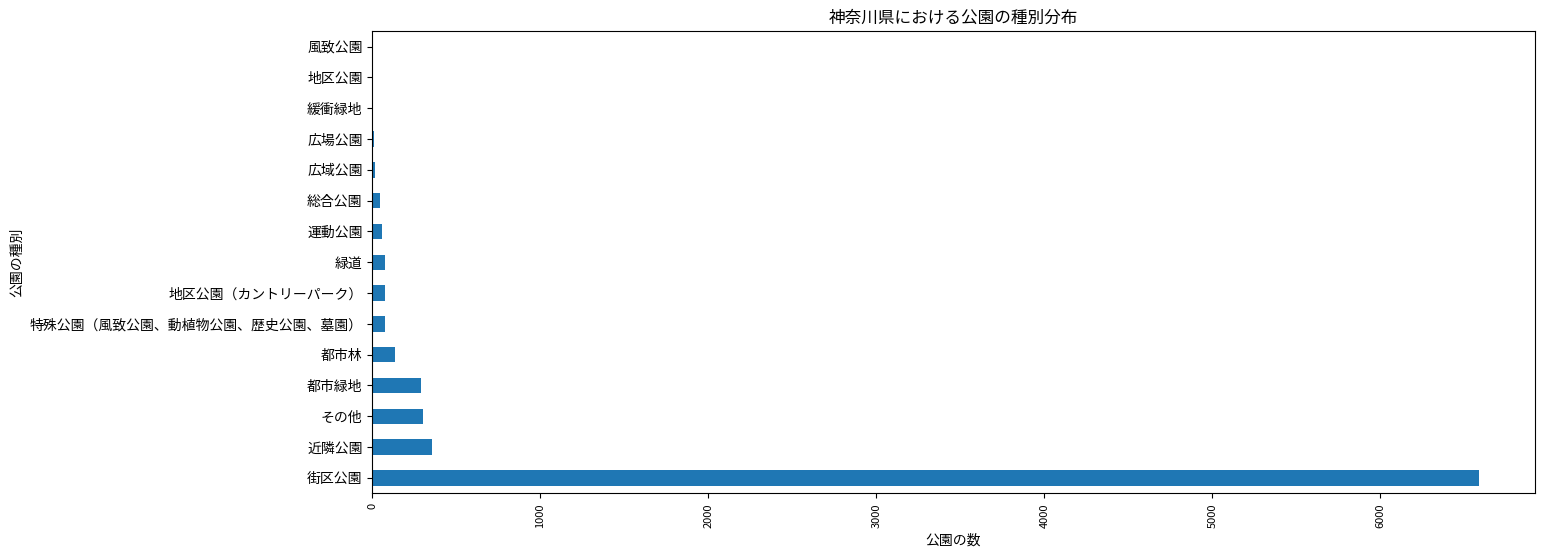

In [109]:
#神奈川県における公園の種別分布
# カテゴリ別に集計
category_counts = park_data['公園種別'].value_counts()

# グラフのサイズを設定
plt.figure(figsize=(15, 6))  # グラフのサイズを15x6インチに設定

# 横棒グラフを描画
category_counts.plot(kind='barh', stacked=True)  # 横棒グラフの描画
plt.title('神奈川県における公園の種別分布')
plt.ylabel('公園の種別')
plt.xlabel('公園の数')
plt.xticks(rotation=90, fontsize=8)
plt.show()


In [111]:
# 各市区町村ごとの公園面積の合計を計算
park_area_sum = park_data.groupby('所在地')['面積'].sum().reset_index()
print(administrative_area.columns)

# 行政区域面積データの結合
park_area_sum = park_area_sum.merge(administrative_area, on='行政区域面積')

# 公園面積密度の計算
park_area_sum['公園面積密度'] = park_area_sum['面積'] / park_area_sum['行政区域面積']

# 人口密度データの結合
combined_data = park_area_sum.merge(population_density, on='人口密度')

# 人口密度と公園の面積密度の散布図の描画
plt.scatter(combined_data['人口密度'], combined_data['公園面積密度'])
plt.xlabel('人口密度')
plt.ylabel('公園面積密度')
plt.title('市区町村別 人口密度と公園の面積密度')
plt.show()

# 相関分析
correlation = combined_data['人口密度'].corr(combined_data['公園面積密度'])
print(f'相関係数: {correlation}')

Index(['Unnamed: 0', '行政区域面積'], dtype='object')


KeyError: '行政区域面積'